# Finding a Bargain NBA Defensive Ace

Goal: Many metrics exist to quantify the defensive impact of NBA players. The difficulty of such measures is that it five players (of varying capabilities) are on the floor at any given time. Metrics such as defensive efficiency when a given player is on the floor cannot be directly compared between members of different teams; even a good defensive player on a bad defensive team is likely to be poor in this metric compared to a bad defensive player on a good team.

Instead, let's establish a quantitative estimate (in added/removed points) of the impact of on-ball defense for each player. Compare each player's performance against their present salary to find market value.

How: Compare the effective FG % (eFG%) for each offensive player j on average to the eFG% when guarded by defensive player i. 

Caveat 1: Certain players may play significant defensive minutes against some players and next to none against others. The eFG% differential for each ij pair must be multiplied by the number of shots defended (num_shots[i,j]) so that undue influence is not given to ij pairs with a small sample size.

Caveat 2: We are naturally interested in promising players that are cheap. These may be players that simply don't get large minutes on their current roster, but perform well in the minutes they do receive. Therefore, we will normalize all aij pairs on a per-36 minute basis.

---
Note: The formula for effective field goal percentage is (FGM + 0.5* 3PM) / FGA, where FGM is field goals made (all), 3PM is the number of 3 point shots made, and FGA is field goals attempted (all). This accounts for the fact that when a lower probability 3 point shot is made, 50% more points are awarded.

---

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix

In [2]:
shot_logs = pd.read_csv('shot_logs.csv')

In [3]:
shot_logs.head()

,Unnamed: 0,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


The shot_logs dataset seen above was taken from kaggle at the following location:

https://www.kaggle.com/datasets/dansbecker/nba-shot-logs

The dataframe is a complete log of data on every shot taken in the 2014-2015 NBA season. Of most interest to us are the following columns:
- PTS_TYPE: the points awarded for the shot based on court location, if made
- SHOT_RESULT: made or missed
- CLOSEST_DEFENDER, player_name: the former is the name of the player defending the shot; the latter is the name of the shooter
- CLOSEST_DEFENDER_PLAYER_ID, player_id: unique player id #s for both the defender and shooter
- FGM: 1 or 0 for made/missed

The dataset is listed as coming from the API for www.nba.com/stats., which I used myself to generate some additional data needed for this analysis.

-----------------------------

#### More on the unique ID numbers player_id and CLOSEST_DEFENDER_PLAYER_ID:

These IDs are not continuous (the lowest is 708 and the highest is 530027) so for further analysis it is helpful to convert them into IDs from 0 to n-1, where n is the total number of players in the dataset.

We'll base "n" on the CLOSEST_DEFENDER_PLAYER_ID column unique entries, which outnumber the player_id unique entries. This is because certain players within the dataset have logged minutes playing defense, but have not themselves attempted a shot.

The code blocks below transform the player IDs into logical indices.

In [4]:
shot_logs[['CLOSEST_DEFENDER_PLAYER_ID', 'player_id']].head()

,CLOSEST_DEFENDER_PLAYER_ID,player_id
0,101187,203148
1,202711,203148
2,202711,203148
3,203900,203148
4,201152,203148


In [5]:
def player_id_to_index(shot_df):
    ## converts the player_id and CLOSEST_DEFENDER_PLAYER_ID to logical matrix i, j values of 0 to n-1
    
    shots = shot_df.copy()
    
    sorted_player_ids = np.sort(shots.CLOSEST_DEFENDER_PLAYER_ID.unique())
    num_players = len(sorted_player_ids)
    new_indices = list(range(0, num_players))
    
    dictionary = {s: n for s,n in zip(sorted_player_ids, new_indices)}
    
    shots['player_id'] = shots['player_id'].map(dictionary)
    shots['CLOSEST_DEFENDER_PLAYER_ID'] = shots['CLOSEST_DEFENDER_PLAYER_ID'].map(dictionary)
    
    return shots

In [6]:
shot_logs = player_id_to_index(shot_logs)

In [7]:
shot_logs[['CLOSEST_DEFENDER_PLAYER_ID', 'player_id']].head()

,CLOSEST_DEFENDER_PLAYER_ID,player_id
0,107,337
1,281,337
2,281,337
3,400,337
4,133,337


---------------------------
Let's also build a utility function which returns a dictionary mapping of each player's id to their name. It'll be useful later when we try to interpret whether our results make sense.

In [8]:
def id_to_player(shot_df):
    shots = shot_df.copy()
    
    unique_ids = shots.CLOSEST_DEFENDER_PLAYER_ID.unique().tolist()    
    players = [shots.CLOSEST_DEFENDER[shots.CLOSEST_DEFENDER_PLAYER_ID == u].reset_index(drop=True)[0] for u in unique_ids]
    
    return {u: p for u,p in zip(unique_ids, players)}

---------------
Our next step is to analyze the dataset to return some statistics on each player. What we're ultimately looking for is an effective field goal percentage for each player across all defenders for the 2014-2015 season. To ensure the results are logical, we'll also show our work by including in the data from the cumuluative field goals made, field goals attempted, and three point field goals made.

As a default, the function will return all results regardless of defender. We'll also set it up so that if we have a particular defender of interest, we can enter their ID and return statistics for players when our player of interest is defending.

In [9]:
def get_efg_by_player(shot_df, defender_id = None):
    # select a player_id to return data on only one player. leave as "none" to return all players
    
    if defender_id is not None:
        shots = shot_df[shot_df.CLOSEST_DEFENDER_PLAYER_ID == defender_id]
    else:
        shots = shot_df.copy()
    
    fgm_series = shots.groupby('player_id').FGM.sum()
    fga_series = shots.player_id.value_counts().sort_index()
    
    only_threes = shots[(shots.SHOT_RESULT == 'made') & (shots.PTS_TYPE == 3)]
    three_made_series = only_threes.player_id.value_counts().sort_index()
    
    efg_table = pd.DataFrame({'FGM': fgm_series, 'three_made': three_made_series, 'FGA': fga_series})
    
    # some players have not attempted three point shots. Fill NaN with 0.
    efg_table['three_made'] = efg_table['three_made'].fillna(0).astype(int)
    
    efg_table['eFG_perc'] = (efg_table.FGM + (0.5 * efg_table.three_made)) / efg_table.FGA
    
    efg_table.reset_index(inplace=True)
    efg_table.columns = ['player_id', 'FGM', 'three_made', 'FGA', 'eFG_perc']
    
    return efg_table

Let's test the functions above by seeing who our top shooters are in terms of eFG.

In [10]:
test_efg_results = get_efg_by_player(shot_logs)
test_efg_results['player_name'] = test_efg_results.player_id.map(id_to_player(shot_logs))

test_efg_results.sort_values(by=['eFG_perc'], ascending=False)

,player_id,FGM,three_made,FGA,eFG_perc,player_name
121,178,276,0,386,0.715026,"Jordan, DeAndre"
13,17,230,0,340,0.676471,"Chandler, Tyson"
42,60,230,173,469,0.674840,"Korver, Kyle"
133,197,189,10,303,0.640264,"Johnson, James"
162,236,69,49,148,0.631757,"Babbitt, Luke"
...,...,...,...,...,...,...
1,1,244,48,658,0.407295,"Bryant, Kobe"
182,265,53,8,141,0.404255,"Fredette, Jimmer"
62,90,66,23,196,0.395408,"Robinson, Nate"
168,246,153,13,422,0.377962,"Stephenson, Lance"


Some may be surprised that stars such as Lebron James or Kobe Bryant (who was still one of the highest paid players in the NBA in the 2014 season) are not found at the top of this list. However, this is to be expected. 

These players often do not have the luxury of shooting only "good" shots; they often must shoot more often and under increased defensive pressure. It is not surprising therefore, to have our two highest percentage players be DeAndre Jordan and Tyson Chandler. The bulk of the shots these players attempt are dunks and put-backs (shots very close to the basket). 

Likewise, spot number 3 is occupied by Kyle Korver, who is one of the most successful three point shooters in NBA history. Because these shots result in 50% more points, Kyle Korver's eFG% is particularly high. 

In [11]:
djordan_avg_dist = shot_logs[shot_logs.player_name == 'deandre jordan'].SHOT_DIST.mean()
tchandler_avg_dist = shot_logs[shot_logs.player_name == 'tyson chandler'].SHOT_DIST.mean()
lbj_avg_dist = shot_logs[shot_logs.player_name == 'lebron james'].SHOT_DIST.mean()

print('DeAndre Jordan average shot distance ==> {} feet'.format(round(djordan_avg_dist,2)))
print('Tyson Chandler average shot distance ==> {} feet'.format(round(tchandler_avg_dist,2)))
print('Lebron James average shot distance ==> {} feet'.format(round(lbj_avg_dist,2)))

print()

print('Kyle Korver 3PM ===> {}'.format(test_efg_results[test_efg_results.player_name == 'Korver, Kyle'].three_made.values))
print('Kobe Bryant 3PM ===> {}'.format(test_efg_results[test_efg_results.player_name == 'Bryant, Kobe'].three_made.values))

DeAndre Jordan average shot distance ==> 3.42 feet
Tyson Chandler average shot distance ==> 4.13 feet
Lebron James average shot distance ==> 13.88 feet

Kyle Korver 3PM ===> [173]
Kobe Bryant 3PM ===> [48]


-----------------
Now that we have effective field goal percentage regardless of defender, let's build a matrix of effective fg percentage for each player against specific defenders. As previously stated, we will multiply the resulting eFG% by the number of shots taken by each offensive player. This will place greater weight on players that our defender of interest has guarded for 50 shots, instead of just one.

In fact, this information already exists wtih our get_efg_by_player() function. Let's check the results if we drop in defender_id = 0 (Kevin Garnett).

In [12]:
test_efg_results = get_efg_by_player(shot_logs, defender_id = 0)
test_efg_results['player_name'] = test_efg_results.player_id.map(id_to_player(shot_logs))
test_efg_results.head(10)

,player_id,FGM,three_made,FGA,eFG_perc,player_name
0,5,0,0,2,0.000000,"Pierce, Paul"
1,18,0,0,2,0.000000,"Gasol, Pau"
2,22,0,0,4,0.000000,"Randolph, Zach"
3,27,1,0,1,1.000000,"Andersen, Chris"
4,30,5,0,14,0.357143,Nene
5,31,4,0,6,0.666667,"Stoudemire, Amar'e"
6,41,0,0,1,0.000000,"James, LeBron"
7,42,3,1,7,0.500000,"Anthony, Carmelo"
8,43,0,0,2,0.000000,"Bosh, Chris"
9,44,3,0,4,0.750000,"Wade, Dwyane"


The above dataset shows the statistics for each offensive player while defended by Kevin Garnett.

Now let's iteratively generate such filtered data sets to build our matrix. We'll use a coo format and scipy's coo_matrix function to order the data.

In [13]:
def efg_by_defender(shot_df):
    shots = shot_df.copy()[['FGM', 'player_id', 'SHOT_RESULT', 'PTS_TYPE', 'CLOSEST_DEFENDER_PLAYER_ID']]
    
    m = shots.CLOSEST_DEFENDER_PLAYER_ID.max() + 1
    
    rows, cols, vals, fgas = [], [], [], []
    
    for i in range(m):
        local_df = get_efg_by_player(shots, defender_id = i)
        
        rows += [i]*local_df.shape[0]
        cols += local_df.player_id.tolist()
        vals += local_df['eFG_perc'].tolist()
        fgas += local_df['FGA'].tolist()
                 
    return coo_matrix((vals, (rows, cols)), shape=(m,m)).toarray(), coo_matrix((fgas, (rows, cols)), shape=(m,m)).toarray()

In [14]:
defender_matrix, fgas_matrix = efg_by_defender(shot_logs)

We have now built 2 (m,m) matrices, one holding the eFG% for shooter j against defender i, and the second holding the number of field goals attempted for the same pair.

As stated previously, some players have logged defensive stats but have not themselves put up a shot. To keep the matrix dimensions consistent (and to avoid storing columns with only zeros) we will filter them out of the matrices using the code blocks below:

In [15]:
def find_non_shooters(shot_df):
    ### return ids for players which show up as defenders but not shooters.
    shooters = shot_df.player_id.unique().tolist()
    defenders = shot_df.CLOSEST_DEFENDER_PLAYER_ID.unique().tolist()
    
    return np.array([d for d in defenders if d not in shooters])

In [16]:
remove_js = find_non_shooters(shot_logs)

In [17]:
defender_matrix_reduce = np.delete(defender_matrix, remove_js, 1)
fgas_matrix_reduce = np.delete(fgas_matrix, remove_js, 1)

In [18]:
defender_matrix_reduce.shape

(448, 273)

The final code block shows the shape of the new matrices; 175 columns have been removed from the "shooter" category, and the defender category is unchanged.

Now we need to normalize our defender matrix.

For each eFG% entry for shooter j and defender i, we will subtract the eFG% of shooter j across all defenders. Then we multiply by the total field goals attempted by shooter j on defender i, to ensure proper weighting of each cell.

In [19]:
def compare_to_league_average(shot_df, dij_matrix, fgas_matrix):
    # update the dij matrix by: (eFG_dij - eFG_dj) * FGA_ij
    eFG_all_league = get_efg_by_player(shot_df).sort_values(by='player_id').set_index('player_id')
    
    # reshape into a row vector for subsequent broadcasting
    eFG_dj = eFG_all_league['eFG_perc'].to_numpy().reshape((1, eFG_all_league.shape[0]))
    
    # with respect to others in league
    dij_matrix_normalized = dij_matrix - eFG_dj
    
    # multiply by FGA_ij (field goals attempted by shooter j against defender i)
    dij_final = dij_matrix_normalized * fgas_matrix
    
    return dij_final

In [20]:
defenders_to_league_avg = compare_to_league_average(shot_logs, defender_matrix_reduce, fgas_matrix_reduce)

Let's have a look at the first five rows and columns. As expected, many entries are empty (meaning that certain players have never defended one another).

In [21]:
defenders_to_league_avg[:5,:5]

array([[-0.        , -0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.82509506,  0.49191542],
       [-0.        , -0.62917933, -0.        , -0.41254753, -0.50808458],
       [-0.        , -0.        ,  0.50323102, -0.        , -0.50808458],
       [-0.        ,  0.59270517, -0.        , -0.        , -0.        ]])

--------
Now that we have our matrix in the correct format, let's take the sum of each row (i.e., each defender). That should tell us the extra points allowed(+) or prevented(-) for each player.

In [22]:
sums_by_defender = np.sum(defenders_to_league_avg, axis=1)
sums_by_defender[:10]

array([ -4.65524123,  16.62572111, -30.79347024,   4.14236261,
        32.18944781,  -6.33861189,  -2.25763848,  -3.89362129,
       -19.26610011,  -8.08052724])

In [23]:
unique_ids = np.sort(shot_logs['CLOSEST_DEFENDER_PLAYER_ID'].unique()).tolist()

In [24]:
defensive_impact_df = pd.DataFrame({'id': unique_ids, 'impact': sums_by_defender.tolist()})
defensive_impact_df['player_name'] = defensive_impact_df['id'].map(id_to_player(shot_logs))
defensive_impact_df = defensive_impact_df.reindex(columns = ['id', 'player_name', 'impact'])

defensive_impact_df.sort_values(by='impact', ascending=True)

,id,player_name,impact
318,318,"Green, Draymond",-54.308156
171,171,"Ibaka, Serge",-51.702467
368,368,"Gobert, Rudy",-47.473007
80,80,"Bogut, Andrew",-45.291450
131,131,"Noah, Joakim",-38.318152
...,...,...,...
428,428,"Wiggins, Andrew",28.470792
86,86,"Frye, Channing",28.827156
401,401,"Payton, Elfrid",31.159000
4,4,"Nowitzki, Dirk",32.189448


These results are very encouraging; recall that negative values imply the player's presence on the floor is removing opposing team baskets, relative to some randomly selected defender. The top five defenders by this metric are:

Draymond Green   ==>   3x NBA all-defensive first team selection, 1x NBA defensive player of the year
Serge Ibaka      ==>   3x NBA all-defensive first team selection, 2x NBA blocks leader
Andrew Bogut     ==>   1x NBA all-defensive second team selection, 1x NBA blocks leader
Rudy Gobert      ==>   5x NBA all-defensive first team selection, 3x NBA defensive player of the year
Anthony Davis    ==>   2x NBA all-defensive first team selection, 3x NBA blocks leader

Note that these award totals are as of present day (April 23, 2022), rather than as of 2014-15 (the dataset's season).

In short, the metric passes the sanity check. But there's one problem. Many of these players are likely to have accumulated their stats over a greater amount of time (or possessions) on the court. That means we're undervaluing players with less playing time (who are ultimately cheaper for us to acquire via trade or free agency). So let's place our "impacts" in terms of a consistent unit of time.


The following dataframe of minutes logged by each player in 2014-15 was pulled from www.nba.com/stats using an API called nba_api. Pulling the data was a relatively lengthy process, which is not reproduced here for fear of sluggishness (or the possibility that the API will not run in Vocareum).

In [25]:
minutes = pd.read_csv('mins_by_player.csv')

In [26]:
minutes.head()

,Unnamed: 0,id,total_mins_played
0,384,708,952.0
1,263,977,1207.0
2,53,1495,2227.0
3,290,1713,1091.0
4,215,1717,2282.0


Once the minute 'id' column is mapped to our analysis' index (0 to n-1), we can merge the apply the results to our dataset.

In [27]:
sorted_player_ids = np.sort(minutes.id.unique()).tolist()

num_players = len(unique_ids)
new_indices = list(range(0, num_players))
dictionary = {s: n for s,n in zip(sorted_player_ids, new_indices)}

In [28]:
minutes['player_index'] = minutes['id'].map(dictionary)

In [29]:
minutes.sort_values(inplace=True, by='player_index')

In [30]:
minutes.head()

,Unnamed: 0,id,total_mins_played,player_index
0,384,708,952.0,0
1,263,977,1207.0,1
2,53,1495,2227.0,2
3,290,1713,1091.0,3
4,215,1717,2282.0,4


When NBA stats are normalized to a set time period, 36 minutes is the default used. This equates to approximately 75% of actual game time, and is often about the maximum that any given player averages per game in regular season play.

We'll maintain this convention here, and place our player impact in terms of 36 minute increments.

In [31]:
per_time_impact_by_defender = (sums_by_defender / minutes['total_mins_played'])*36

In [32]:
defensive_impact_df_per_time = pd.DataFrame({'id': unique_ids, 'impact_per_time': per_time_impact_by_defender.tolist()})
defensive_impact_df_per_time['player_name'] = defensive_impact_df_per_time['id'].map(id_to_player(shot_logs))
defensive_impact_df_per_time = defensive_impact_df_per_time.reindex(columns = ['id', 'player_name', 'impact_per_time'])

defensive_impact_df_per_time.sort_values(by='impact_per_time', ascending=True)

,id,player_name,impact_per_time
391,391,"Lucas, Kalin",-2.843787
316,316,"James, Bernard",-1.915979
385,385,"Mekel, Gal",-1.860648
13,13,"Martin, Kenyon",-1.451091
25,25,"Dalembert, Samuel",-1.214224
...,...,...,...
392,392,"Christopher, Patrick",4.626392
99,99,"Turiaf, Ronny",4.671841
379,379,"Nogueira, Lucas",5.295435
424,424,"Kirk, Alex",5.943556


Let's also have a look at the distribution of minutes played. While we definitely want to find diamonds in the rough, we probably don't want to trust these results for players that haven't played much at all. These players often come in in "garbage time", when the opposing team's starters have all been removed from the game already.

C:\Users\parso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='total_mins_played'>

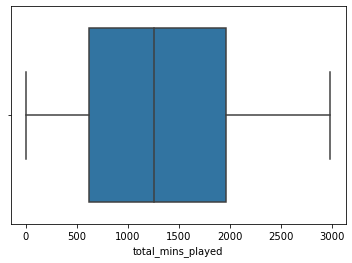

In [33]:
import seaborn as sns

sns.boxplot(minutes['total_mins_played'])

In [34]:
minutes['total_mins_played'].describe()

count     448.000000
mean     1283.508929
std       799.041056
min         2.000000
25%       616.000000
50%      1260.000000
75%      1958.000000
max      2981.000000
Name: total_mins_played, dtype: float64

Let's go ahead and rule out any players below the 25th percentile.

In [35]:
def get_player_indices_to_keep(minutes_frame, threshold_mins):
    minutes_df = minutes_frame.copy()
    
    idx = [i for i,m in zip(minutes_df['player_index'], minutes_df['total_mins_played']) if m >= threshold_mins]
    return idx

In [36]:
keep_idx = get_player_indices_to_keep(minutes, minutes['total_mins_played'].describe()['25%'])

A quick sanity check to ensure we indeed removed the right percentage:

In [37]:
print("Proportion removed: {}".format((minutes.shape[0] - len(keep_idx)) / (minutes.shape[0])))

Proportion removed: 0.25


Now, returning to our defensive impact matrix:

In [38]:
filtered_def_impact_df = defensive_impact_df_per_time[defensive_impact_df_per_time['id'].isin(keep_idx)]
filtered_def_impact_df.rename({'id': 'player_index'}, axis=1, inplace=True)

minutes_reduced_df = minutes[minutes['player_index'].isin(keep_idx)]

filtered_def_impact_df = filtered_def_impact_df.merge(minutes_reduced_df, on='player_index')
filtered_def_impact_df = filtered_def_impact_df[['player_index', 'player_name', 'impact_per_time', 'total_mins_played']]

filtered_def_impact_df.nsmallest(10, 'impact_per_time')

C:\Users\parso\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,player_index,player_name,impact_per_time,total_mins_played
66,80,"Bogut, Andrew",-1.030001,1583.0
140,171,"Ibaka, Serge",-0.879626,2116.0
298,368,"Gobert, Rudy",-0.791950,2158.0
260,318,"Green, Draymond",-0.785178,2490.0
254,307,"Jones, Terrence",-0.738470,889.0
134,164,"Hibbert, Roy",-0.690306,1926.0
283,345,"Roberson, Andre",-0.688010,1286.0
105,131,"Noah, Joakim",-0.673233,2049.0
208,255,"Millsap, Elijah",-0.632216,924.0
250,302,"Lamb, Jeremy",-0.565986,633.0


We can see some familiar faces, though there's some shifting around at the top (Andrew Bogut is now our best defender). WE can also have a look at the total minutes played by each player.

-------------------------------------

Finally, we can marry this all up with salary data for the 2014-15 season to see if we can find any bargains.
For this, I used beautifulsoup and a regular expression to extract the data needed from html encoding of another website:

https://hoopshype.com/salaries/players/2014-2015/

In [46]:
player_salaries = pd.read_csv('player_salaries.csv')
player_salaries.head(10)

,Player,Salary
0,Kobe Bryant,23500000
1,Joe Johnson,23180790
2,Carmelo Anthony,22458401
3,Amare Stoudemire,21896658
4,Dwight Howard,21436271
5,LeBron James,20644400
6,Chris Bosh,20644400
7,Chris Paul,20068563
8,Kevin Durant,19997513
9,Deron Williams,19754465


In our existing dataset, our player names are in the format Last, First. This new salaries dataframe has the format First, Last. Let's fix that and then marge the two dataframes together.

In [40]:
def convert_to_last_first(list_of_names):
    converted_names = []
    for n in list_of_names:
        name_sections = n.split(' ')
        first = name_sections[0]
        last = " ".join(name_sections[1:])
        
        converted_names.append(last + ", " + first)
    
    return converted_names

In [41]:
player_salaries_2 = player_salaries.copy()
player_salaries_2['Player'] = convert_to_last_first(player_salaries.Player)
player_salaries_2.rename({'Player': 'player_name'}, axis=1, inplace=True)

In [42]:
final_player_eval = filtered_def_impact_df.merge(player_salaries_2, on='player_name')
final_player_eval['impact_per_million_dollar'] = final_player_eval['impact_per_time'] / (final_player_eval['Salary']/1E6)

display(final_player_eval)

,player_index,player_name,impact_per_time,total_mins_played,Salary,impact_per_million_dollar
0,0,"Garnett, Kevin",-0.176039,952.0,12000000,-0.014670
1,1,"Bryant, Kobe",0.495879,1207.0,23500000,0.021101
2,2,"Duncan, Tim",-0.497784,2227.0,10361446,-0.048042
3,3,"Carter, Vince",0.136687,1091.0,3911981,0.034941
4,4,"Nowitzki, Dirk",0.507809,2282.0,7974482,0.063679
...,...,...,...,...,...,...
318,439,"Rudez, Damjan",0.034353,1047.0,1100000,0.031230
319,442,"Black, Tarik",0.468288,1195.0,507336,0.923034
320,443,"Wear, Travis",0.049938,672.0,507336,0.098431
321,444,"Galloway, Langston",-0.471466,1457.0,295455,-1.595730


#### Finally! Now, let's sort!

In [43]:
final_player_eval.nsmallest(10, 'impact_per_time')[['player_name', 'impact_per_time', \
                                                    'total_mins_played', 'impact_per_million_dollar']]

,player_name,impact_per_time,total_mins_played,impact_per_million_dollar
62,"Bogut, Andrew",-1.030001,1583.0,-0.079396
132,"Ibaka, Serge",-0.879626,2116.0,-0.071806
286,"Gobert, Rudy",-0.791950,2158.0,-0.702457
249,"Green, Draymond",-0.785178,2490.0,-0.857890
243,"Jones, Terrence",-0.738470,889.0,-0.456217
126,"Hibbert, Roy",-0.690306,1926.0,-0.046333
272,"Roberson, Andre",-0.688010,1286.0,-0.592662
99,"Noah, Joakim",-0.673233,2049.0,-0.053010
198,"Millsap, Elijah",-0.632216,924.0,-2.097478
240,"Lamb, Jeremy",-0.565986,633.0,-0.257033


So we can see that despite Andrew Bogut's status as the best individual defensive player (by this metric, at least), he is far from the best deal.

At the time of this dataset's generation (2014-2015) players like Draymond Green and Rudy Gobert were still new to the NBA and had not yet been paid as the stars they would become. However, we can see some potential in a player like Andre Roberson, who has a relatively large defensive impact but low salary.

Let's sort instead by the impact_per_million_dollar column.

In [44]:
final_player_eval.nsmallest(10, 'impact_per_million_dollar')[['player_name', 'impact_per_time', \
                                                    'total_mins_played', 'impact_per_million_dollar']]

,player_name,impact_per_time,total_mins_played,impact_per_million_dollar
198,"Millsap, Elijah",-0.632216,924.0,-2.097478
321,"Galloway, Langston",-0.471466,1457.0,-1.595730
249,"Green, Draymond",-0.785178,2490.0,-0.857890
286,"Gobert, Rudy",-0.791950,2158.0,-0.702457
277,"Dedmon, Dewayne",-0.548088,845.0,-0.671279
169,"Calathes, Nick",-0.519063,838.0,-0.635731
254,"Hamilton, Justin",-0.489943,713.0,-0.600066
272,"Roberson, Andre",-0.688010,1286.0,-0.592662
267,"Holiday, Justin",-0.467341,657.0,-0.572383
192,"Whiteside, Hassan",-0.431574,1142.0,-0.556733


Elijah Millsap is our value-star. Langston Galloway may actually be a better investment, given a high impact while playing 50% more minutes than Millsap.

From here, the front office of an NBA squad could go any number of directions, perhaps filtering on a certain position (i.e., guards only) or marrying this metric up with offensive metrics (like the eFG% we derived earlier) to ensure the player acquired can do more than simply play defense.

With our original objective achieved, however, this seems like an apt stopping point.